# HYPERPARAMETERS: Type of pooling
In this document the implementation of different pooling methods will be discussed. The different pooling methods used are the following:

*   Maximum
*   Average
*   Nothing

The additions to the code provided are explained in the code itself.











In [1]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision
# The tabulate library is used to show the final results
!pip install tabulate

     |████████████████████████████████| 2.0MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tabulate import tabulate

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [0]:
class Net(nn.Module):
    # We change the constructor of this class in order to allow different types of pooling
    def __init__(self, pooling_type): 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc1Nth = nn.Linear(20*20*50, 500) # In the case of no pooling a different layer must be used because the input size is different
        self.fc2 = nn.Linear(500, 10)
        self.pooling_type = pooling_type

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        if(self.pooling_type == "max"):
          x = F.max_pool2d(x, 2, 2)
          x = F.relu(self.conv2(x))
          x = F.max_pool2d(x, 2, 2)
          x = x.view(-1, 4*4*50)
          x = F.relu(self.fc1(x))

        elif(self.pooling_type == "avg"):
          x = F.avg_pool2d(x, 2, 2)
          x = F.relu(self.conv2(x))
          x = F.avg_pool2d(x, 2, 2)
          x = x.view(-1, 4*4*50)
          x = F.relu(self.fc1(x))
        else:
          x = F.relu(self.conv2(x))
          x = x.view(-1, 20*20*50)
          x = F.relu(self.fc1Nth(x))
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader): 
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)
    validation_accuracy = 100. * correct / len(loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        validation_accuracy))
    
    return validation_loss, validation_accuracy

In [7]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20198287.22it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 313950.99it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5705702.15it/s]                           
8192it [00:00, 128136.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def train_net(type, device):
  train_losses = []
  valid_losses = []
  valid_x = []
  valid_accuracy = []
  # A new model is used for each pooling method
  model = Net(type).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


  print('\x1b[1;31m'+'\n\tType of pooling: {}\t'.format(type)+'\033[0;30m')
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      valid_loss, valid_acc = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_accuracy.append(valid_acc)
      valid_x.append(len(train_losses) - 1)
      

  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.show()
  # In this implementation we also want to see the validation accuracy
  return valid_accuracy


	Type of pooling: max	
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282498
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.580224
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.342452
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.185716
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.370162
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.124976

Validation set: Average loss: 0.1525, Accuracy: 9552/10000 (95.52%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.218684
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.102962
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.162518
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.123956
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.197738
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.097816

Validation set: Average loss: 0.0896, Accuracy: 9730/10000 (97.30%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.096523
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.130213
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.050417
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.084786
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.167129
T

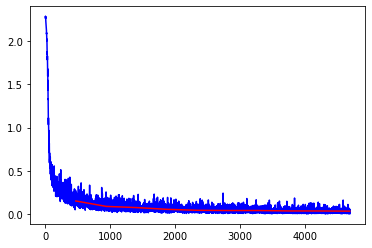


	Type of pooling: avg	
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298285
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.674862
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.517735
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.500943
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.520862
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.424348

Validation set: Average loss: 0.2901, Accuracy: 9167/10000 (91.67%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288438
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.242042
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.244201
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.187071
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.162587
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.170735

Validation set: Average loss: 0.1810, Accuracy: 9474/10000 (94.74%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.201878
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.146500
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.216832
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.183188
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.174220
T

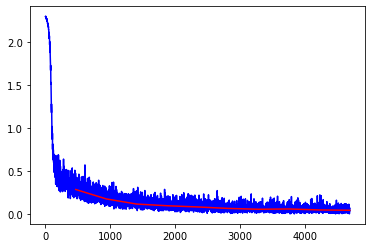


	Type of pooling: nothing	
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301605
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.405962
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.295821
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.171345
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.159069
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.148118

Validation set: Average loss: 0.1493, Accuracy: 9559/10000 (95.59%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144465
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.157239
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.098684
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.118894
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.156791
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.060789

Validation set: Average loss: 0.0848, Accuracy: 9748/10000 (97.48%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.054326
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.061708
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.053018
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.015360
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.1053

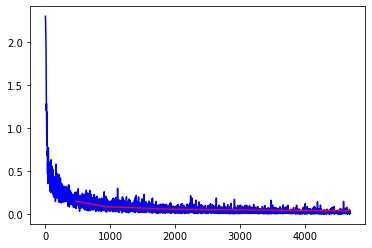



Epoch        1      2      3      4      5      6      7      8      9     10
-------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
Maximum  95.52  97.3   97.68  98.34  98.63  98.61  98.57  98.74  98.82  98.79
Average  91.67  94.74  96.3   96.98  97.28  97.77  98.1   97.85  98.28  98.41
Nothing  95.59  97.48  97.78  98.24  98.46  98.36  98.53  98.62  98.62  98.68


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 10


pooling = ["max","avg","nothing"]
trainloss={"max":["Maximum"], "avg":["Average"], "nothing":["Nothing"]}

# We run three training sessions, one for each pooling method
for type in pooling:
  trainloss[type].extend(train_net(type, device))

print("\n")
print(tabulate([trainloss["max"], trainloss["avg"], trainloss["nothing"]], ["Epoch", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))


#Conclusions
After running the experiment, it can be concluded that the best pooling method is, with the dataset provided, the Maximum-Pooling. This shows that the higher value elements are more important than the rest of the values. This can also be seen looking at the average pooling method. With this method a lower accuracy and a higher loss is obtained. This is beacuse it takes every value into account with the same importance (so the maximum value has less importance than before). Finally without using pooling, the accuracy rate and loss obtained is in between the previous two pooling methods. This method would also require more computational capacity because no pooling is used and it works with more samples.